In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.graphics.tsaplots

In [2]:
sns.set(style='whitegrid', palette="Set2", color_codes=True)
%matplotlib inline

In [3]:
Project_Dir = os.getcwd()
Processed_Data_Dir = Project_Dir + r"/Processed_Data"

In [4]:
DATA_UNDLY=pd.read_csv(Processed_Data_Dir+'/Underlyings.csv',usecols=np.arange(1,6),parse_dates=['Date'])

In [5]:
DATA_UNDLY.shape

(4938, 5)

In [6]:
DATA_UNDLY.head()

,Date,Close,Fig,Ten_ma,pct_chg
0,2015-08-20,287.5,GASL,355.7,-0.066558
1,2015-08-21,261.5,GASL,350.3,-0.090435
2,2015-08-24,216.0,GASL,332.7,-0.173996
3,2015-08-25,205.5,GASL,316.1,-0.048611
4,2015-08-26,227.0,GASL,296.7,0.104623


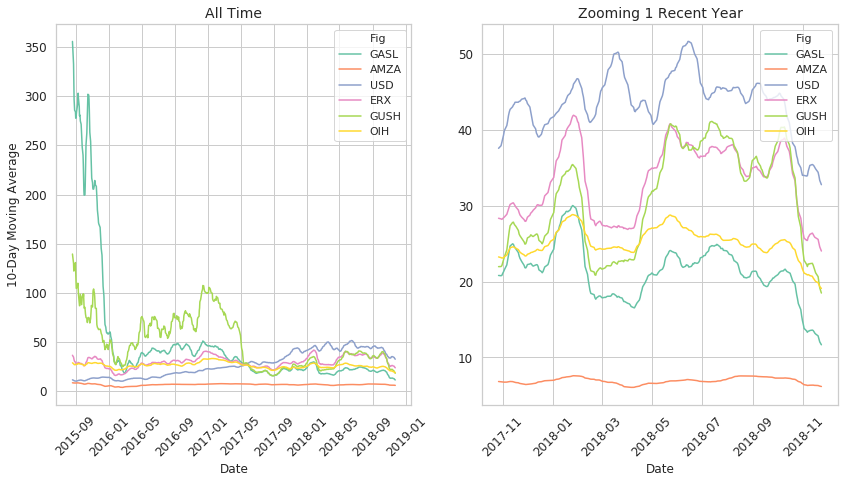

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(data=DATA_UNDLY,hue='Fig',y='Ten_ma',x='Date',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(ylabel='10-Day Moving Average',title='All Time')

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>"2017-10-26"],hue='Fig',y='Ten_ma',x='Date',ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(ylabel='',title='Zooming 1 Recent Year')
for ax in ax:
    for item in ([ax.yaxis.label,ax.xaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#     ax.set(title='Suggested Weight Adjustment For KAM\'s Features\n')
    # ax.xaxis.label.set_fontsize(13)
    ax.title.set_fontsize(14)
# plt.show()

In [8]:
dt_undly=DATA_UNDLY

* Get Rid of underlyings with low volatility

# Test GBM's Assumption 

* Correlation

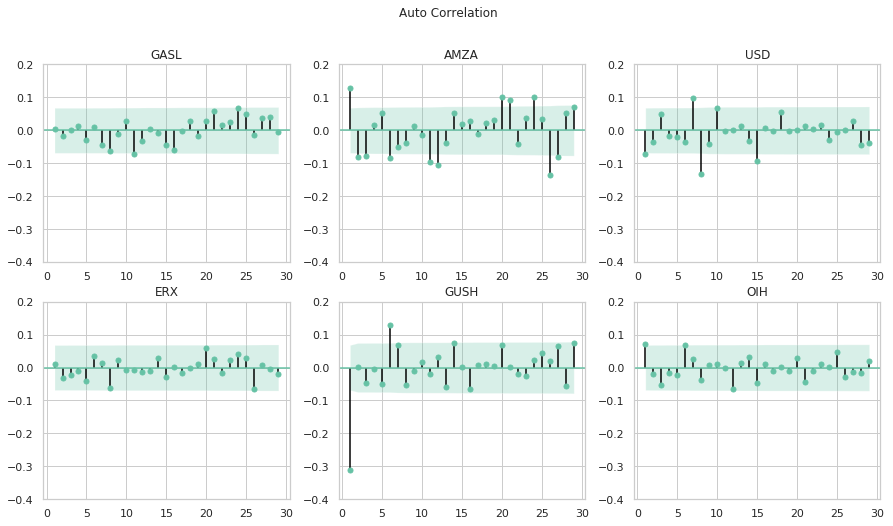

In [9]:
nrow,ncol,ax_ind=2, 3,0
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Auto Correlation')
gs1 = gridspec.GridSpec(nrow,ncol)
ax_ls = [fig.add_subplot(ss) for ss in gs1]
for fig in dt_undly.Fig.unique():
    ax=ax_ls[ax_ind]
    statsmodels.graphics.tsaplots.plot_acf(x=dt_undly[dt_undly.Fig==fig].pct_chg,unbiased=False, lags=np.arange(1,30)
                                           ,alpha=0.05,ax=ax)
    ax.set(title=fig,ylim=(-0.4,0.2))
    ax_ind+=1

* Choose growth window for each underlyinng

Eyball: Choose 2 day as project lap.

In [21]:
g_window=dict(zip(dt_undly.Fig.unique().tolist(),[1,4,4,1,2,3]))
g_window

{'GASL': 1, 'AMZA': 4, 'USD': 4, 'ERX': 1, 'GUSH': 2, 'OIH': 3}

#  Jarque-Bera Test

In [22]:
from scipy.stats import jarque_bera

In [23]:
data_close_pvt=dt_undly[['Date','Close','Fig']].pivot(index='Date',columns='Fig')
data_close_pvt.columns=data_close_pvt.columns.droplevel(0)

In [24]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,8.46,32.13,287.5,139.21,27.15,10.58
2015-08-21,8.22,28.83,261.5,125.06,26.26,9.99
2015-08-24,7.92,24.18,216.0,106.41,24.90,9.75
2015-08-25,7.88,23.03,205.5,98.23,24.90,9.37
2015-08-26,8.49,25.43,227.0,104.81,25.84,10.13


In [25]:
jb_result=[]
for col in data_close_pvt.columns:
    window=g_window[col]
    gamma=data_close_pvt[col].pct_change(window)
    jb_result.append(
        [col,window]+
        list(
            jarque_bera(gamma.dropna().values)
        )
    )
pd.DataFrame(jb_result,columns=['Fig','Window','JB_Val','P_Val'])

,Fig,Window,JB_Val,P_Val
0,AMZA,4,1865.309149,0.000000
1,ERX,1,76.445066,0.000000
2,GASL,1,782.893855,0.000000
3,GUSH,2,3024.206357,0.000000
4,OIH,3,102.606641,0.000000
5,USD,4,22.862180,0.000011


# Generate Underlying Price 

* Mean, Std, Corr

In [41]:
mean_std=[]
for col in data_close_pvt.columns:
    window=g_window[col]
    gamma=data_close_pvt[col].pct_change(window)
    mean_std.append(
        [col,window]+[gamma.mean(),gamma.std()]+\
        []
    )
pd.DataFrame(mean_std,columns=['Fig','Window','Mean','std'])

AssertionError: 4 columns passed, passed data had 5 columns

In [38]:
data_close_pvt['AMZA'].pct_change(4)

Date
2015-08-20         NaN
2015-08-21         NaN
2015-08-24         NaN
2015-08-25         NaN
2015-08-26    0.003100
2015-08-27    0.097001
2015-08-28    0.139073
2015-08-31    0.141172
2015-09-01    0.008653
2015-09-02   -0.047702
2015-09-03   -0.034302
2015-09-04   -0.035554
2015-09-08    0.012132
2015-09-09   -0.010996
2015-09-10   -0.023480
2015-09-11   -0.067191
2015-09-14   -0.076159
2015-09-15   -0.057443
2015-09-16   -0.047472
2015-09-17    0.023037
2015-09-18   -0.002621
2015-09-21    0.026868
2015-09-22   -0.012298
2015-09-23   -0.082778
2015-09-24   -0.057162
2015-09-25   -0.090619
2015-09-28   -0.141546
2015-09-29   -0.170125
2015-09-30   -0.069686
2015-10-01   -0.014035
                ...   
2018-10-12   -0.030464
2018-10-15   -0.034346
2018-10-16    0.005376
2018-10-17    0.005487
2018-10-18   -0.002732
2018-10-19   -0.008208
2018-10-22   -0.042966
2018-10-23   -0.046931
2018-10-24   -0.093089
2018-10-25   -0.082633
2018-10-26   -0.092199
2018-10-29   -0.097384
2018-1

In [27]:
data_close_pvt.columns

Index(['AMZA', 'ERX', 'GASL', 'GUSH', 'OIH', 'USD'], dtype='object', name='Fig')

In [97]:
data_close_pvt.describe()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,6.915711,30.135692,48.171397,49.169707,26.385358,27.733600
std,0.855429,5.751987,61.706407,27.631722,2.909993,12.854218
min,3.684273,14.178413,10.050000,13.582627,18.190001,9.371198
25%,6.657159,26.431273,21.064999,25.569237,24.394999,14.582064
50%,7.106954,29.688633,28.299999,38.951221,26.199986,25.464329
75%,7.453390,34.414484,42.555000,68.841793,28.218953,41.233307
max,9.024482,43.237911,363.700012,151.335861,34.037975,53.058846


In [151]:
dt_gamma2=data_close_pvt.pct_change(2)

In [152]:
dt_gamma2.head()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-21,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-24,-0.063856,-0.247332,-0.248696,-0.235652,-0.082730,-0.078927
2015-08-25,-0.042119,-0.201224,-0.214149,-0.214581,-0.051675,-0.062317
2015-08-26,0.071523,0.051459,0.050926,-0.015018,0.037580,0.039601


,Fig,JB_Val,P_Val
0,AMZA,3984.514708,0.0
1,ERX,170.462347,0.0
2,GASL,1343.924841,0.0
3,GUSH,3024.206357,0.0
4,OIH,84.478748,0.0
5,USD,94.533859,0.0


In [116]:
dt_gamma2['AMZA'].dropna().values

array([-6.38559862e-02, -4.21185438e-02,  7.15231014e-02,  1.45236530e-01,
        6.30406947e-02, -3.54874808e-03, -5.11628257e-02, -4.43107609e-02,
        1.77696127e-02,  9.16288382e-03, -5.53889129e-03, -1.99756591e-02,
       -1.80407655e-02, -4.81777976e-02, -5.91863010e-02, -9.73407689e-03,
        1.24512215e-02,  3.30930567e-02, -1.48869471e-02, -6.02594406e-03,
        2.62797444e-03, -7.72176343e-02, -5.96328980e-02, -1.45228705e-02,
       -8.71080084e-02, -1.57894723e-01,  1.90839972e-02,  1.70833446e-01,
        1.01872548e-01,  1.09608542e-01,  3.97867021e-02,  6.96512815e-03,
        5.07099844e-02,  6.91695070e-03, -3.60359196e-02, -4.08898567e-02,
       -1.46862738e-02,  1.90995940e-02,  2.57452119e-02, -1.27172085e-02,
       -1.91546750e-02, -1.42375669e-02, -5.31985581e-02, -4.26409682e-02,
       -4.48081965e-02, -6.75288271e-02,  2.30827795e-02,  9.24500422e-02,
        4.80348935e-02,  2.96192494e-02,  5.34723920e-02,  0.00000000e+00,
       -6.32827443e-02, -

In [105]:
dt_gamma2.columns

Index(['AMZA', 'ERX', 'GASL', 'GUSH', 'OIH', 'USD'], dtype='object', name='Fig')

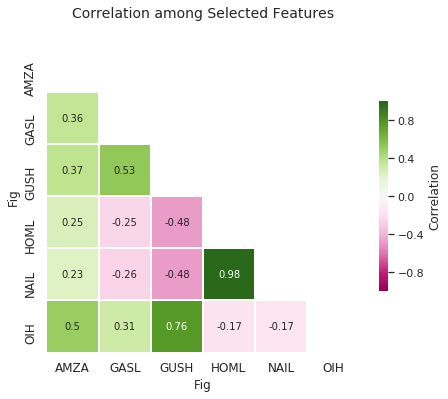

In [10]:
corr=data_close_pvt.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7, 7))
with sns.axes_style(style='white'):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1,
                     square=True,
#                      xticklabels=labs_heatmap_x,
#                      yticklabels=labs_heatmap_y,
                     center=0,
                     annot=True,
                     # ax=ax,
                     cmap="PiYG",
                     linewidths=.5,
                     cbar_kws={"shrink": .5,
                               'label': 'Correlation'
                               }
                     )
for item in ([ax.yaxis.label,ax.xaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.set(title='Correlation among Selected Features\n')
ax.title.set_fontsize(14)
plt.show()


In [11]:
data_chg_pvt=data[['Date','pct_chg','Fig']].pivot(index='Date',columns='Fig')
data_chg_pvt.columns=data_chg_pvt.columns.droplevel(0)

In [12]:
data_chg_pvt.head().round(3)

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
Date,,,,,,
2015-08-20,-0.036,-0.067,-0.081,-0.044,-0.052,-0.028
2015-08-21,-0.029,-0.090,-0.102,-0.032,-0.055,-0.033
2015-08-24,-0.036,-0.174,-0.149,-0.115,0.000,-0.052
2015-08-25,-0.006,-0.049,-0.077,-0.064,-0.071,0.000
2015-08-26,0.078,0.105,0.067,0.060,-0.156,0.038


In [13]:
data_chg_pvt.describe()[1:3]

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
mean,-0.000189,-0.001434,0.022781,0.000217,0.000495,-0.000328
std,0.023730,0.073394,0.252690,0.030317,0.041396,0.019669


In [14]:
data_close_pvt.cov()

Fig,AMZA,GASL,GUSH,HOML,NAIL,OIH
Fig,,,,,,
AMZA,0.731759,18.913427,8.721908,2.811449,3.919790,1.249996
GASL,18.913427,3807.680681,909.575396,-195.874916,-240.748777,55.520895
GUSH,8.721908,909.575396,763.512061,-172.854218,-267.229358,60.977748
HOML,2.811449,-195.874916,-172.854218,167.452579,254.453819,-6.503737
NAIL,3.919790,-240.748777,-267.229358,254.453819,397.097861,-9.786324
OIH,1.249996,55.520895,60.977748,-6.503737,-9.786324,8.468061


In [15]:
def sim_NTL(mu,cov,NTR):
    result=[]
    for n in range(NTR):    
        z_sim=np.column_stack([np.random.multivariate_normal(1+mu,cov,24),[1.0085]*24])    
        result.append(np.append(z_sim.prod(0),
                                [z_sim.prod(0).mean(),z_sim.mean(1).prod()])*100)
    return result

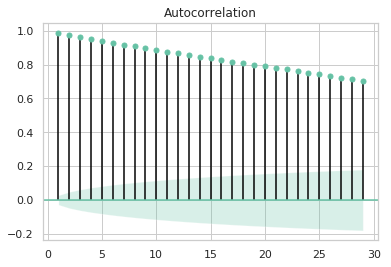

In [24]:
ax=statsmodels.graphics.tsaplots.plot_acf(x=data.Ten_ma, lags=np.arange(1,30),alpha=0.05)

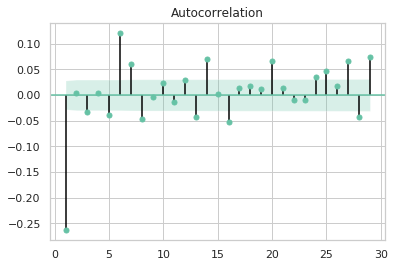

In [17]:
ax=statsmodels.graphics.tsaplots.plot_acf(x=data.pct_chg,unbiased=False, lags=np.arange(1,30),alpha=0.05)

ax=statsmodels.graphics.tsaplots.plot_pacf(x=data.pct_chg, lags=np.arange(1,30),alpha=0.05)